In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from hydramuscle.model.smc import SMC
from hydramuscle.model.layer import Layer

In [3]:
def plot_moments(data, moments, dt=0.0002, save_interval=100, cmap='viridis', vmin=None, vmax=None):
    indices = [int(x/dt/save_interval) for x in moments]
    
    if not vmin and not vmax:
        vmin = np.min(data[indices[1]])
        vmax = np.max(data[indices[1]])

    fig = plt.figure(figsize=(20, 5))
    ax1 = fig.add_subplot(141)
    ax1.imshow(data[indices[0]].T, vmin=vmin, vmax=vmax, cmap=cmap)
    ax1.set_title(str(moments[0]) + 's')
    ax2 = fig.add_subplot(142)
    ax2.imshow(data[indices[1]].T, vmin=vmin, vmax=vmax, cmap=cmap)
    ax2.set_title(str(moments[1]) + 's')
    ax3 = fig.add_subplot(143)
    ax3.imshow(data[indices[2]].T, vmin=vmin, vmax=vmax, cmap=cmap)
    ax3.set_title(str(moments[2]) + 's')
    ax4 = fig.add_subplot(144)
    im = ax4.imshow(data[indices[3]].T, vmin=vmin, vmax=vmax, cmap=cmap)
    ax4.set_title(str(moments[3]) + 's')
    
    position = fig.add_axes([0.925, 0.2, 0.005, 0.625])
    cb = plt.colorbar(im, cax=position, orientation='vertical')
#     cb.set_label('stress(N/mm$^2$)', fontsize=LABELSIZE)

    plt.show()

In [4]:
numx = 100
numy = 100
T = 50
dt = 0.0002
save_interval=100

In [5]:
# Construct a square muscle sheet as testbed

smc = SMC(T=T, dt=dt, k_ipr=0.2, s0=100, k_deg=0.01)
layer = Layer(smc, 
              numx=numx, 
              numy=numy, 
              gip3x=1, 
              gip3y=1, 
              gcx=1000, 
              gcy=1000,
              save_interval=save_interval,
              active_v_beta=5)

In [6]:
# Set slow stimulation pattern
layer.reset_stim_pattern()
layer.set_stim_pattern(pathway='slow',
                       xmin=0, xmax=-1, ymin=0, ymax=-1,
                       randomnum=8, neighborsize=2,
                       stim_times=[0])
# layer.set_stim_pattern(pathway='slow',
#                        xmin=50, xmax=52, ymin=60, ymax=62,
#                        stim_times=[0])

In [7]:
# Run simulation
sol = layer.run()

100%|██████████| 250000/250000 [05:07<00:00, 812.73it/s]


In [8]:
# Analyze results
c = sol[:, 0 : numx*numy].reshape(-1, numx, numy)
ip = sol[:, 3*numx*numy : 4*numx*numy].reshape(-1, numx, numy)

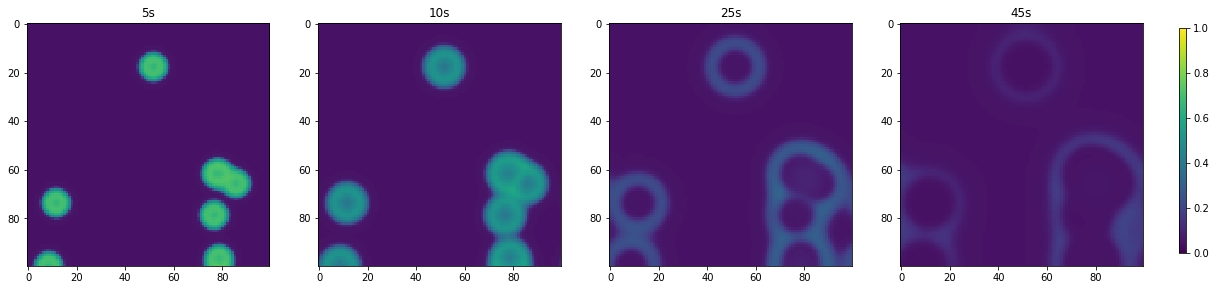

In [9]:
# Plot the calcium concentration
plot_moments(c, [5, 10, 25, 45], vmin=0, vmax=1)

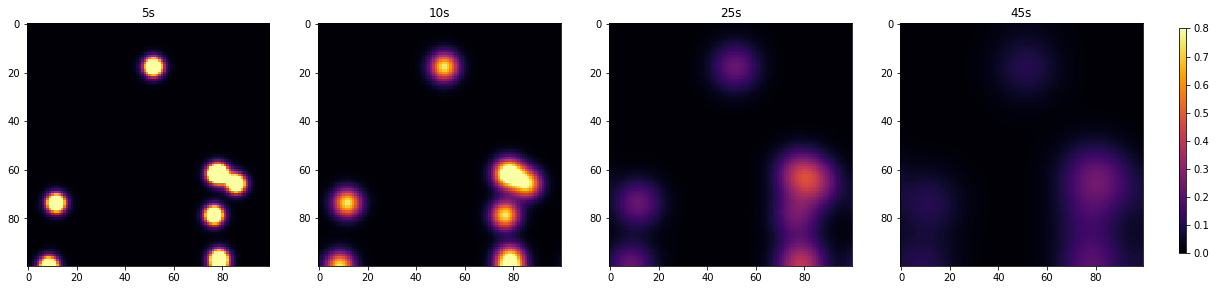

In [15]:
# Plot the IP3 concentration
plot_moments(ip, [5, 10, 25, 45], cmap='inferno', vmin=0, vmax=0.8)

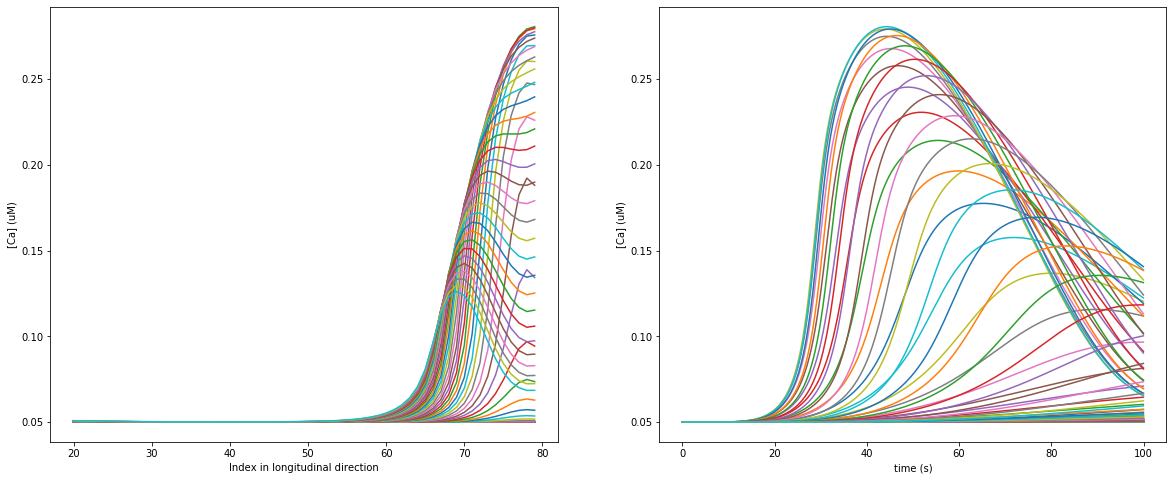

In [11]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(121)
ax1.plot(range(20, 80), c[0::50, 20:80, 50].T)
ax1.set_xlabel('Index in longitudinal direction')
ax1.set_ylabel('[Ca] (uM)')

ax2 = fig.add_subplot(122)
ax2.plot(np.arange(0, 100, 0.04), c[:int(100/dt/save_interval), :, 50])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('[Ca] (uM)')
# ax2.set_xlim(0, 0.1)
# ax2.bar(x=0.005, height=0.2, width=0.01, bottom=-50.5, color='k')
# ax2.set_ylim(-51, -38)
plt.show()

100%|██████████| 500/500 [00:29<00:00, 17.07it/s]


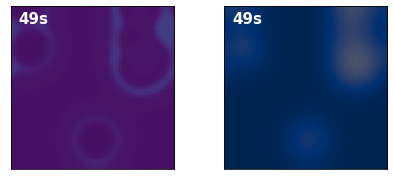

In [16]:
from tqdm import tqdm

# Save video
numx = 30
numy = 60
dpi = 100
fps = 200
savepath = '../results/videos/calcium/'

fig = plt.figure(figsize=(700/dpi, 300/dpi))

for iframe in tqdm(range(0, len(c), 5)):

    plt.clf()

    frame_ecto = c[iframe]
    frame_endo = ip[iframe]
    frame_ecto = np.flip(frame_ecto.T, 0)
    frame_endo = np.flip(frame_endo.T, 0)
    
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(frame_ecto, vmin=0, vmax=1)
    ax1.set_xticks([])
    ax1.set_yticks([])
#     ax1.patch.set_edgecolor('g')  
    ax1.patch.set_alpha(1)
    ax1.patch.set_linewidth('10')  
    ax1.text(0.05, 0.9, str(int(iframe*0.02)) + 's', size=15, weight="bold", color='white', transform=ax1.transAxes)
    
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(frame_endo, cmap='cividis', vmin=0, vmax=0.8)
    ax2.set_xticks([])
    ax2.set_yticks([])
#     ax2.patch.set_edgecolor('r')  
    ax2.patch.set_alpha(1)
    ax2.patch.set_linewidth('10') 
    ax2.text(0.05, 0.9, str(int(iframe*0.02)) + 's', size=15, weight="bold", color='white', transform=ax2.transAxes)

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())

#     plt.xlim(0, numx)
#     plt.ylim(0, numy)
#     plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0, wspace=0)
    plt.margins(0, 0)

    plt.savefig(savepath + 'frames/img' + str(iframe) + '.jpg', dpi=dpi)


In [17]:
from cv2 import cv2

fourcc = cv2.VideoWriter_fourcc(*'MJPG')
videoWriter = cv2.VideoWriter(savepath + '/video.avi', fourcc, fps, (700, 300))

for iframe in tqdm(range(len(c))):
    frame = cv2.imread(savepath + 'frames/img' + str(iframe) + '.jpg')
    videoWriter.write(frame)
videoWriter.release()
cv2.destroyAllWindows()

100%|██████████| 2500/2500 [00:01<00:00, 1439.43it/s]
